# MelSpectrogram CNN Autoencoder for Denoising

### Introduction

In this project, we explore the application of convolutional neural networks (CNNs) for denoising mel-spectrograms. Mel-spectrograms are a representation of audio signals in the frequency domain, widely used in speech processing and audio analysis tasks. Denoising mel-spectrograms involves removing unwanted noise from audio signals, which is crucial for various applications such as speech recognition, music processing, and audio classification.

We leverage the concept of autoencoders, a type of neural network architecture capable of learning efficient representations of data by encoding input signals into a lower-dimensional space and then decoding them back to the original space. The autoencoder is trained in an unsupervised manner, meaning it learns to reconstruct the input data without explicit labels.

### Dataset

The dataset utilized in this project comprises mel-spectrograms that I generated by converting audio recordings (.wav files) of spoken digits from the MNIST dataset **[Audio MNIST](https://www.kaggle.com/datasets/alanchn31/free-spoken-digits)** using the Librosa library. Each mel-spectrogram represents a single digit pronounced in English, ranging from 0 to 9. In the dataset we have 3000 mel-spectrograms in total, 300 for every digit. The dataset is split into training and testing sets, with 300 mel-spectrograms per digit in the training set and 30 mel-spectrograms per digit in the testing set (2700 - 300).

#### Convert audio (.wav) dataset to melspectrogram (.npy) dataset

In [22]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split


# Melspectrogram parameters
sr = 22050
n_fft = 2048
hop_length = 512
n_mels = 128
fixed_length = 8000

# Original dataset path (.wav files)
audio_folder = 'recordings/'

# Function to convert audio to melspectrogram
def process_audio(file_path, sr=22050):
    y, sr = librosa.load(file_path, sr=sr)
    y = librosa.util.fix_length(y, size=fixed_length)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    return mel

# List to store the melspectrograms
X = []

# Iterate over each audio file in the folder
for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):
        file_path = os.path.join(audio_folder, filename)
        mel = process_audio(file_path)
        X.append(mel)

X = np.array(X)
np.save('X.npy', X)

# Split the dataset into train set and test set, then save as .npy files
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)
np.save('train_data.npy', X_train)
np.save('test_data.npy', X_test)

# (2700, 128, 16), (300, 128, 16)
print("Shape of train_data:", X_train.shape)
print("Shape of test_data:", X_test.shape)

# Save the train set and test set as a .npz file
np.savez('dataset.npz', train_data=X_train, test_data=X_test)

Shape of train_data: (2700, 128, 16)
Shape of test_data: (300, 128, 16)


#### Pre-process and load data

In [75]:
import numpy as np

# Normalization and reshape
def preprocess(array: np.array):
    array = array.astype("float32")/255.0
    array = np.reshape(array, (len(array), 128, 16, 1))
    print("Final Shape:", array.shape)

    return array

# Add random noise to the numpy array (Gaussian noise)
def noise(array):
    noise_factor = 0.00000005 
    noise_array = array + noise_factor * \
        np.random.normal(loc=0.0, scale=1, size=array.shape)

    return np.clip(noise_array, 0.0, 1.0)

# With this function we can load our data from dataset.npz, which has train_data.npy and test_data.npy inside
def load_data(path="dataset.npz"):
    with np.load("dataset.npz", allow_pickle=True) as f:
        train_data, test_data = f['train_data'], f['test_data']

    print(train_data.shape)
    # (2700, 128, 16)
    print(test_data.shape)
    # (300, 128, 16)
    
    train_data = preprocess(train_data)
    test_data = preprocess(test_data)

    return train_data, test_data


# Load the data
train_data, test_data = load_data()

# Create a copy of the train and test data with noise, this is going to be input for the model
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

(2700, 128, 16)
(300, 128, 16)
Final Shape: (2700, 128, 16, 1)
Final Shape: (300, 128, 16, 1)


### Model Architecture

We design a CNN-based autoencoder architecture tailored for processing mel-spectrograms. The encoder part of the network consists of convolutional layers followed by max-pooling layers to progressively reduce the dimensionality of the input mel-spectrograms. The decoder part mirrors the encoder, using transposed convolutional layers to upsample the encoded features back to the original dimensions.

In [2]:
from tensorflow import keras
from keras import layers, models

# CNN Autoencoder model for processing melspectrograms (with (128, 16) shape)
def build_model(input_shape=(128, 16, 1)):
    input = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="Conv1")(input)
    x = layers.MaxPooling2D((2, 2), padding='same', name='Pool1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2')(x)
    x = layers.MaxPooling2D((2, 2), padding='same', name='Pool2')(x)

    # Decoder
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same', name="Conv1_transpose")(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same', name='Conv2_transpose')(x)
    output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="output_layer")(x)

    autoencoder = models.Model(input, output, name='AutoEncoder-Model')
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder


# Build the model and show summary
model = build_model()
model.summary()

Model: "AutoEncoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 16, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 128, 16, 32)       320       
                                                                 
 Pool1 (MaxPooling2D)        (None, 64, 8, 32)         0         
                                                                 
 Conv2 (Conv2D)              (None, 64, 8, 64)         18496     
                                                                 
 Pool2 (MaxPooling2D)        (None, 32, 4, 64)         0         
                                                                 
 Conv1_transpose (Conv2DTra  (None, 64, 8, 64)         36928     
 nspose)                                                         
                                                 

### Training

The autoencoder is trained using the noisy mel-spectrograms as input and the clean mel-spectrograms as the target output. We introduce random noise to the input mel-spectrograms to simulate real-world noisy audio signals. The model is trained using the Adam optimizer and binary cross-entropy loss function.

In [3]:
# Training of the model
def train_model(checkpoint_dir="tmp", monitor="val_loss"):
    autoencoder = build_model()
    autoencoder.summary()

    early_stopping = keras.callbacks.EarlyStopping(
        monitor=monitor,
        patience=5,
        restore_best_weights=True)

    model_checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_dir,
        monitor=monitor,
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="auto",
        save_freq="epoch",
        options=None)

    autoencoder.fit(
        x=noisy_train_data,
        y=train_data,
        epochs=20,
        batch_size=128,
        shuffle=True,
        validation_data=(noisy_test_data, test_data),
        callbacks=[early_stopping, model_checkpoint])
    
    autoencoder.save('saved_model')

#### Results

After training the autoencoder, we evaluate its performance by comparing the denoised mel-spectrograms generated by the model with the original clean mel-spectrograms. We visualize the results to assess the effectiveness of the denoising process and measure the quality of the reconstructed mel-spectrograms.

In [7]:
from matplotlib import pyplot as plt
import librosa

def display_melspectrogram(noisy_mel, denoised_mel, sr=22050, n=5):
    """
    Display multiple comparisons of melspectrograms with noise and denoised melspectrograms.

    Args:
    - noisy_mel: Melspectrograms with noise (shape: [num_samples, 128, 16, 1]).
    - denoised_mel: Denoised melspectrograms (shape: [num_samples, 128, 16, 1]).
    - sr: Sample rate (default is 22050).
    - n: Number of comparisons to display.
    """
    
    # Select random indexes for showing random test data
    indices = np.random.randint(len(noisy_mel), size=n)

    fig, axes = plt.subplots(2, n, figsize=(16, 8))
    fig.suptitle('Comparison of Noisy and Denoised Melspectrograms', fontsize=16)

    for i, index in enumerate(indices):
    
        noisy_mel_dB = librosa.power_to_db(noisy_mel[index, :, :, 0], ref=np.max)
        denoised_mel_dB = librosa.power_to_db(denoised_mel[index, :, :, 0], ref=np.max)

        # Show noisy melspectrogram
        librosa.display.specshow(noisy_mel_dB, sr=sr, x_axis='time', y_axis='mel', ax=axes[0, i])
        axes[0, i].set(title=f'Noisy {index+1}')

        # Show denoised melspectrogram
        librosa.display.specshow(denoised_mel_dB, sr=sr, x_axis='time', y_axis='mel', ax=axes[1, i])
        axes[1, i].set(title=f'Denoised {index+1}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def show_output():
    try:
        autoencoder = keras.models.load_model(
            "saved_model")  # Load model from 'tmp' folder
    except Exception:
        print("There is no model in the 'tmp' folder, please train the model first")

    predictions = autoencoder.predict(noisy_test_data[..., np.newaxis])
    display_melspectrogram(noisy_test_data, predictions)

In [9]:
train_model()

Model: "AutoEncoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 16, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 128, 16, 32)       320       
                                                                 
 Pool1 (MaxPooling2D)        (None, 64, 8, 32)         0         
                                                                 
 Conv2 (Conv2D)              (None, 64, 8, 64)         18496     
                                                                 
 Pool2 (MaxPooling2D)        (None, 32, 4, 64)         0         
                                                                 
 Conv1_transpose (Conv2DTra  (None, 64, 8, 64)         36928     
 nspose)                                                         
                                                 

INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 28ms/step - loss: 0.5680 - val_loss: 0.1307
Epoch 2/20
16/22 [====================>.........] - ETA: 0s - loss: 0.0895INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 0s 23ms/step - loss: 0.0862 - val_loss: 0.0559
Epoch 3/20
15/22 [===================>..........] - ETA: 0s - loss: 0.0441INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 30ms/step - loss: 0.0412 - val_loss: 0.0295
Epoch 4/20
16/22 [====================>.........] - ETA: 0s - loss: 0.0262INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 25ms/step - loss: 0.0244 - val_loss: 0.0178
Epoch 5/20
15/22 [===================>..........] - ETA: 0s - loss: 0.0169INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0164 - val_loss: 0.0146
Epoch 6/20
15/22 [===================>..........] - ETA: 0s - loss: 0.0148INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0148 - val_loss: 0.0137
Epoch 7/20
16/22 [====================>.........] - ETA: 0s - loss: 0.0139INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0141 - val_loss: 0.0132
Epoch 8/20
16/22 [====================>.........] - ETA: 0s - loss: 0.0136INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 9/20
16/22 [====================>.........] - ETA: 0s - loss: 0.0132INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 31ms/step - loss: 0.0129 - val_loss: 0.0122
Epoch 10/20
15/22 [===================>..........] - ETA: 0s - loss: 0.0124INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 11/20
15/22 [===================>..........] - ETA: 0s - loss: 0.0122INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0120 - val_loss: 0.0114
Epoch 12/20
16/22 [====================>.........] - ETA: 0s - loss: 0.0114INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0115 - val_loss: 0.0111
Epoch 13/20
15/22 [===================>..........] - ETA: 0s - loss: 0.0113INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 25ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 14/20
16/22 [====================>.........] - ETA: 0s - loss: 0.0106INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 15/20
15/22 [===================>..........] - ETA: 0s - loss: 0.0106INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 16/20
16/22 [====================>.........] - ETA: 0s - loss: 0.0100INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 33ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 17/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0094 - val_loss: 0.0100
Epoch 18/20
15/22 [===================>..........] - ETA: 0s - loss: 0.0097INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0089 - val_loss: 0.0095
Epoch 19/20
15/22 [===================>..........] - ETA: 0s - loss: 0.0076INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0080 - val_loss: 0.0089
Epoch 20/20
15/22 [===================>..........] - ETA: 0s - loss: 0.0074INFO:tensorflow:Assets written to: tmp/assets


INFO:tensorflow:Assets written to: tmp/assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0068 - val_loss: 0.0088
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


10/10 [==============================] - 0s 1ms/step


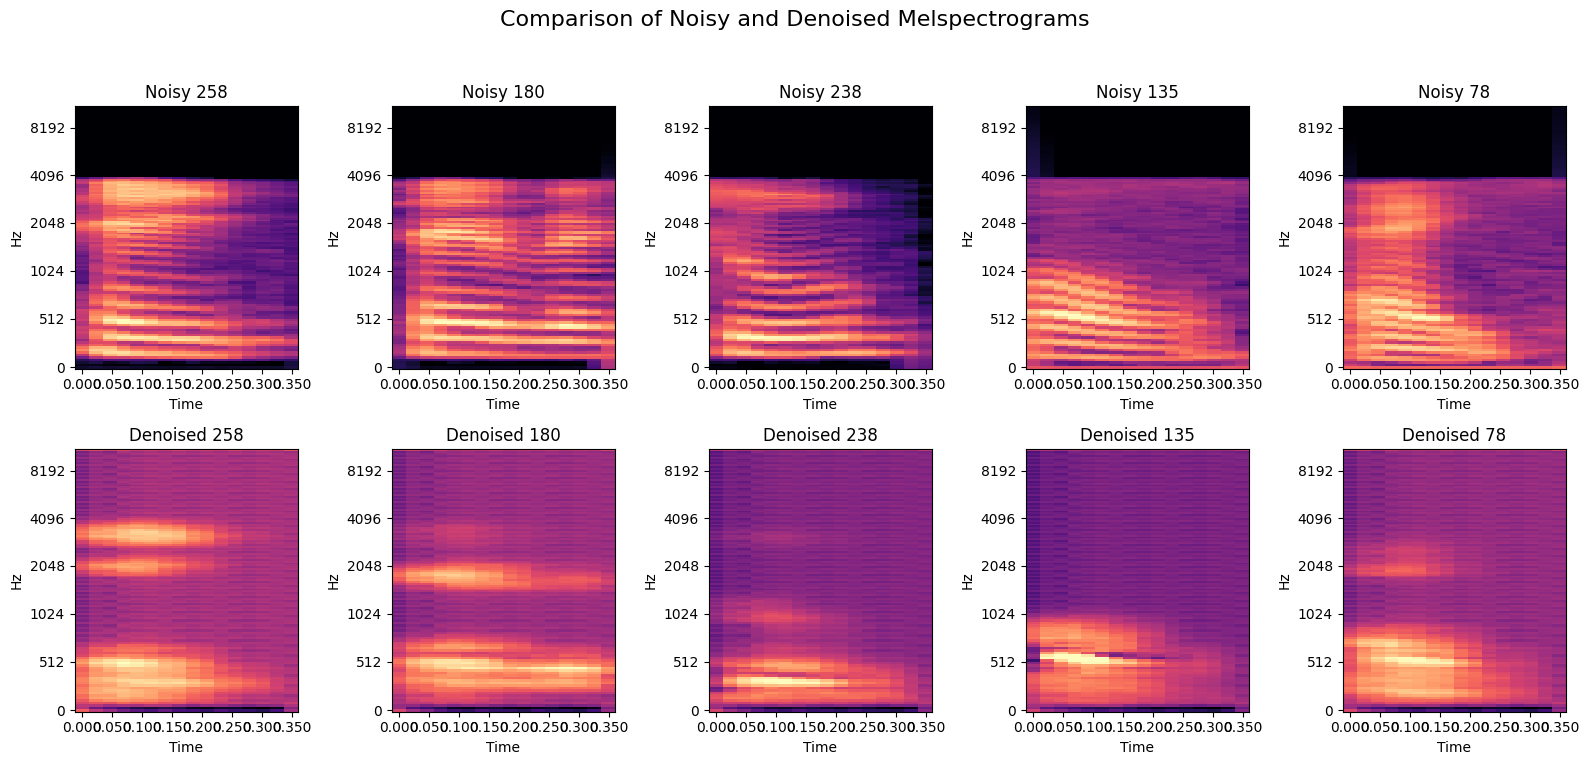

In [16]:
show_output()

#### Some other results

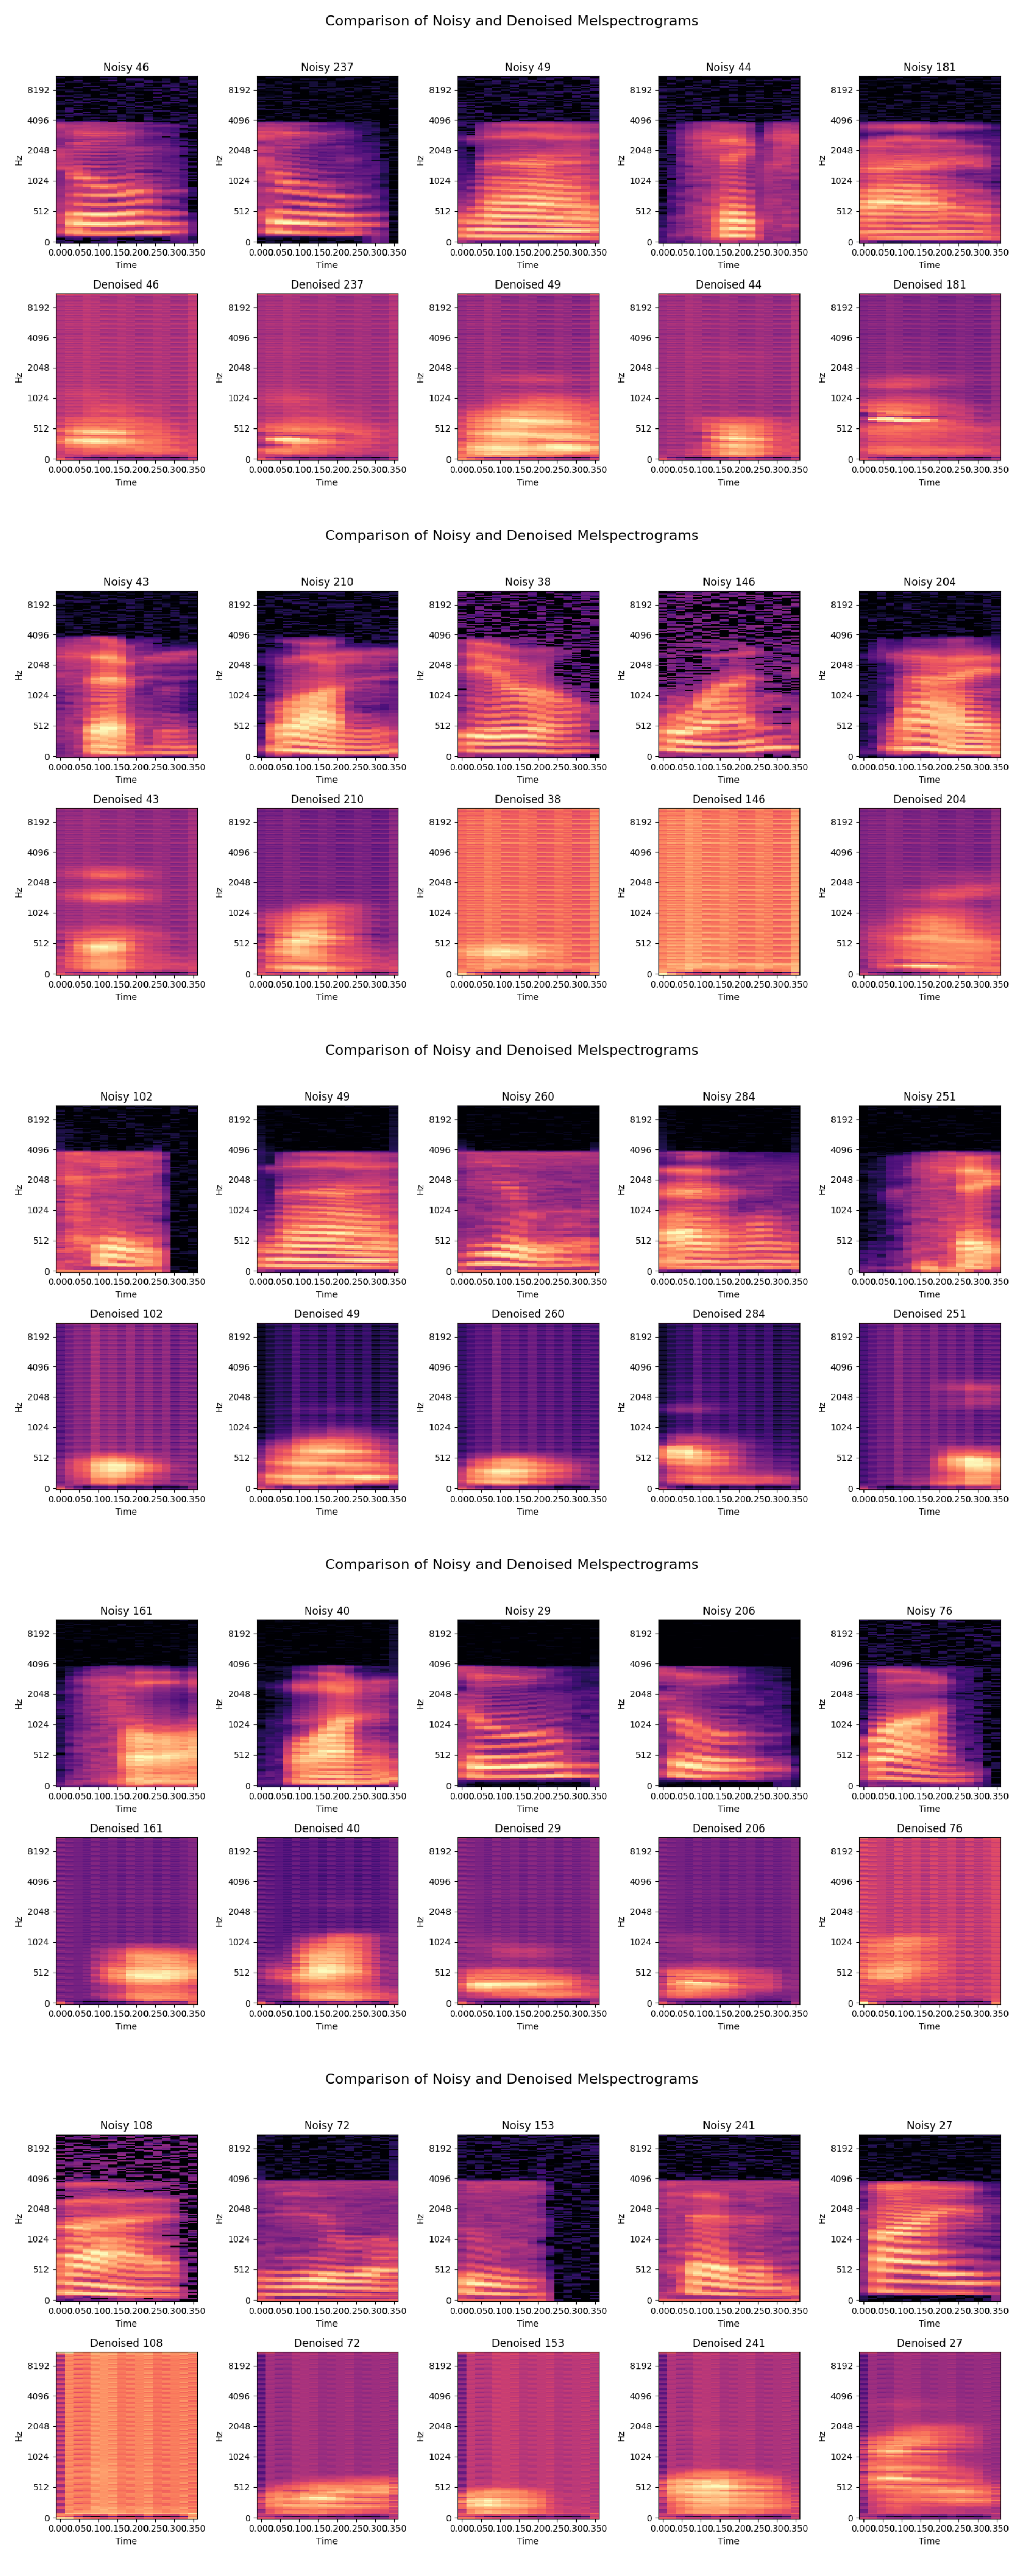

In [17]:
from matplotlib.image import imread

image_paths = ['Figure_5.png', 'Figure_4.png', 'Figure_3.png', 'Figure_2.png', 'Figure_1.png']

plt.figure(figsize=(25, 50))

for i, image_path in enumerate(image_paths, start=1):
    plt.subplot(len(image_paths), 1, i)
    image = imread(image_path)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Inference test for audio denoising

In [42]:
import IPython.display as ipd

audio, sr = librosa.load("recordings/0_george_0.wav")
ipd.Audio(audio, rate=sr)

In [77]:
noisy_audio = noise(audio)
ipd.Audio(noisy_audio, rate = sr)

In [44]:
audio_to_mel = process_audio("recordings/0_george_0.wav")

In [45]:
audio_to_mel.shape

(128, 16)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

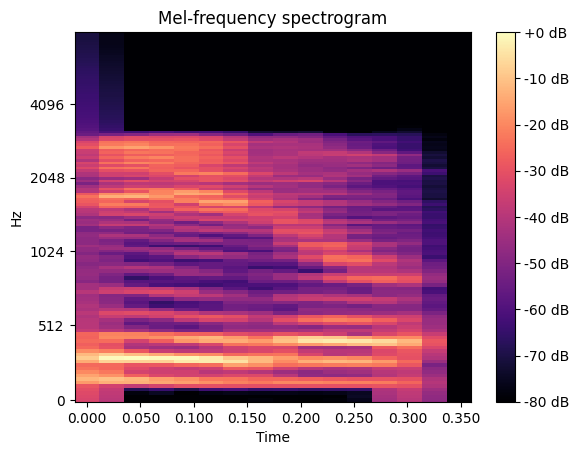

In [46]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(audio_to_mel, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [47]:
noisy_audio = librosa.util.fix_length(noisy_audio, size=fixed_length)
noisy_audio_to_mel = librosa.feature.melspectrogram(y=noisy_audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

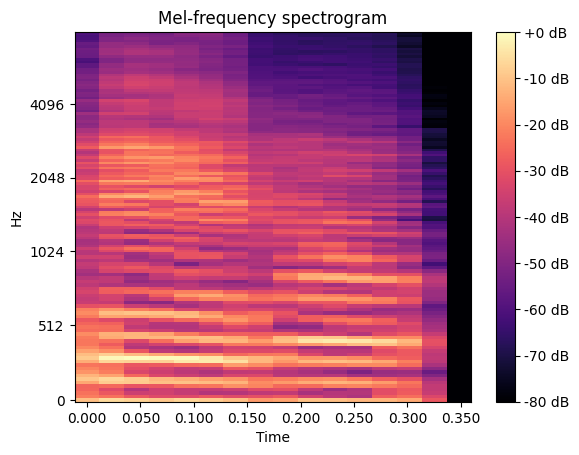

In [48]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(noisy_audio_to_mel, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [49]:
import tensorflow as tf
import numpy as np

noisy_audio_to_mel = np.expand_dims(noisy_audio_to_mel, axis=0)
prediction = autoencoder(noisy_audio_to_mel)

In [52]:
prediction.shape

TensorShape([1, 128, 16, 1])

In [55]:
prediction = np.squeeze(prediction)

In [56]:
prediction.shape

(128, 16)

In [76]:
# Original noisy audio
ipd.Audio(noisy_audio, rate = sr)

In [67]:
import soundfile as sf

def reconstruct_audio(mel, sr, hop_length, n_mels):
  mel_reconstructed = mel[:n_mels, :]
  reconstructed_audio = librosa.feature.inverse.mel_to_audio(mel_reconstructed, sr=sr, hop_length=hop_length)
  sf.write('audio_reconstruido.wav', reconstructed_audio, sr)

  return reconstructed_audio

mel_to_audio = reconstruct_audio(prediction, sr, hop_length, n_mels)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

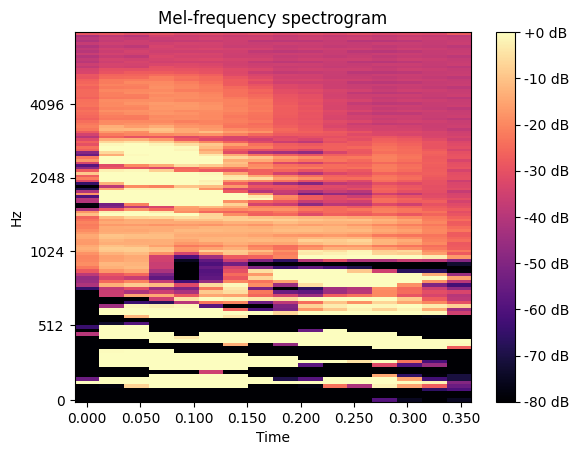

In [57]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(prediction, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [66]:
ipd.Audio(mel_to_audio, rate = sr)

In [68]:
noisy_mel = noise(audio_to_mel)
noisy_mel = np.expand_dims(noisy_mel, axis=0)
denoised_mel = autoencoder(noisy_mel)
denoised_mel = np.squeeze(denoised_mel)

denoised_mel_to_audio = reconstruct_audio(denoised_mel, sr, hop_length, n_mels)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

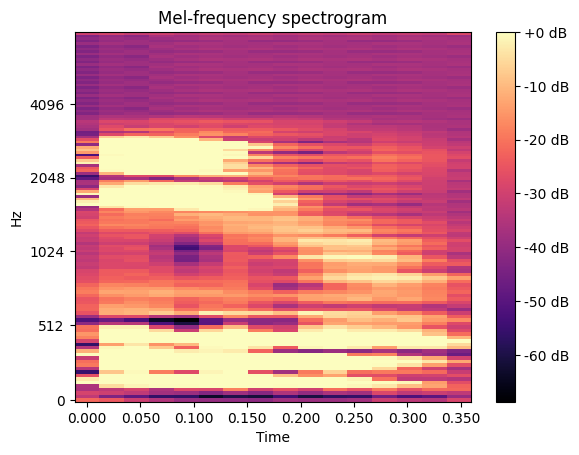

In [69]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(denoised_mel, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [71]:
ipd.Audio(denoised_mel_to_audio, rate = sr)